<a href="https://colab.research.google.com/github/LeonardoGoncRibeiro/PersonalProjects/blob/main/Investments_TimeSeriesAnalysis/StockPrice_Analysis_and_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stock prices: Analysis and prediction

**Important: Past returns do not guarantee future returns.**

**Importante: Rentabilidade obtida no passado não garante rentabilidade futura.**

In this project, I will conduct an analysis experiment on the behavior of some brazilian stock prices. Our goal is to decide which stocks (and, if possible, when) to buy. This is important to understand if a given investment option is sustainable, and if it is able to provide a good profit in the long term. In this project, we will try different approaches to the decision to buy a stock. Basically, we will:

1.   Evaluate stock options based on their average return/risk.

2.   Build a simple model based on comportamental heuristics.

3.   Use the ARMA model to predict stock prices and try to gain profit.

In the end, we will be able to compare these three options (in terms of returns), and understand if we can safely rely in them.

First, let's import the packages that we will be using in this project:

In [70]:
!pip install statsmodels --upgrade --quiet

In [71]:
import pandas as pd                                            # Data collection and manipulation
import numpy as np                                             # Work with arrays

import matplotlib.pyplot as plt                                # Data visualization
import seaborn as sns                                          # Data visualization

from datetime import datetime, timedelta                       # Handle data in the date format

from tqdm import tqdm                                          # Show progress bar in loops

# Modeling

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf  # Autocorrelation and partial autocorrelation funtion plots
from statsmodels.tsa.arima.model import ARIMA                  # ARIMA model

# To ignore warnings

import warnings
from statsmodels.tools.sm_exceptions import ValueWarning, HessianInversionWarning, ConvergenceWarning

warnings.simplefilter(action='ignore', category=FutureWarning) 
warnings.filterwarnings('ignore', category=ValueWarning)
warnings.filterwarnings('ignore', category=HessianInversionWarning)
warnings.filterwarnings('ignore', category=ConvergenceWarning)

In this project, we will consider stock data from '2022-01-01' to '2022-04-30'.

## Data collection

In this project, we will get data from the Yahoo Finance website. So, let's create a simple user defined function to get the stock information:

In [72]:
def DateToUnix(date):
  return pd.to_datetime([date]).astype(int)[0]//10**9

def GetStockData(stock, start, end):
  start = DateToUnix(start)        # convert to unix timestamp.
  end   = DateToUnix(end)        # convert to unix timestamp.

  url = 'https://query1.finance.yahoo.com/v7/finance/download/' + stock + '?period1=' + str(start) + '&period2=' + str(end) + '&interval=1d&events=history'
  return pd.read_csv(url)

In this project, we will analyze some specific stocks from the IBOV index. The IBOV index is the benchmark index of about 91 stocks (this number may change) traded on the B3 (Brasil Bolsa Balcão), accounting for the majority of trading and market capitalization in the Brazilian stock market. We can get information from the indexes from:

https://www.b3.com.br/en_us/market-data-and-indices/indices/stocks-per-index/

In [73]:
indexes_df = pd.read_csv('StockIndex_2022-06-22.csv', sep = ';')
indexes_df.head( )

,Stock,Index
0,MMMC34,BDRX
1,RRRP3,IBOV IBRA IBXX IGCT IGCX IGNM ITAG IVBX SMLL
2,TTEN3,AGFS IBRA ICON IGCT IGCX IGNM ITAG SMLL
3,ABUD34,BDRX
4,A1BB34,BDRX


Now, let's get the stocks that are present in the IBOV index:

In [74]:
def IsIBOV(x):
  return 1 if ('IBOV' in x['Index'].split( )) else 0

In [75]:
indexes_df['IsIBOV'] = indexes_df.apply(IsIBOV, axis = 1)
indexes_df

,Stock,Index,IsIBOV
0,MMMC34,BDRX,0
1,RRRP3,IBOV IBRA IBXX IGCT IGCX IGNM ITAG IVBX SMLL,1
2,TTEN3,AGFS IBRA ICON IGCT IGCX IGNM ITAG SMLL,0
3,ABUD34,BDRX,0
4,A1BB34,BDRX,0
...,...,...,...
652,W1IX34,BDRX,0
653,WIZS3,GPTW IBRA IBXX IDIV IFNC IGCT IGCX IGNM ITAG SMLL,0
654,YDUQ3,IBOV IBRA IBXX ICON IGCT IGCX IGNM ITAG SMLL,1
655,Z1TS34,BDRX,0


In [76]:
IBOV_Stocks = list(indexes_df.query('IsIBOV == 1')['Stock'])

Nice! Let's just check the number of stocks present in the IBOV index:

In [77]:
print(f"There are {len(IBOV_Stocks)} stocks in the IBOV index.")

There are 91 stocks in the IBOV index.


Great! It seems that everything worked out. Now, let's just define a dataframe with these stocks. Later, we will add more information to this dataframe:

In [78]:
IBOV_Stocks_df = pd.DataFrame(IBOV_Stocks, columns = ['Stocks'])

## Checking some stocks

Ok, we have created the function to get stock data from Yahoo Finance, and we also have a list of stocks from the IBOV index. First, let's make some tests, to see if we can gather data correctly.

This test will be performed using the PETR4 stock, from the brazilian oil company PETROBRAS. PETR4 is in the IBOV index:

In [79]:
'PETR4' in IBOV_Stocks

True

Thus, let's get information for PETR4 from Yahoo Finance:

In [80]:
PETR4_df = GetStockData('PETR4.SA', '2022-01-01', '2022-04-30')
PETR4_df.Date = pd.to_datetime(PETR4_df.Date)
PETR4_df.head( )

,Date,Open,High,Low,Close,Adj Close,Volume
0,2022-01-03,28.540001,29.219999,28.530001,29.090000,23.861391,52704700
1,2022-01-04,29.160000,29.400000,28.910000,29.200001,23.951620,51739200
2,2022-01-05,29.190001,29.270000,27.940001,28.070000,23.024725,78459800
3,2022-01-06,28.290001,28.650000,27.840000,28.049999,23.008320,61163100
4,2022-01-07,28.110001,28.290001,27.820000,28.180000,23.114954,47507600


So, here, we have different information about the stock price of PETR4 in the desired period. In this project, we will consider the closing price. Let's see how the stock price changed in the year of 2021:

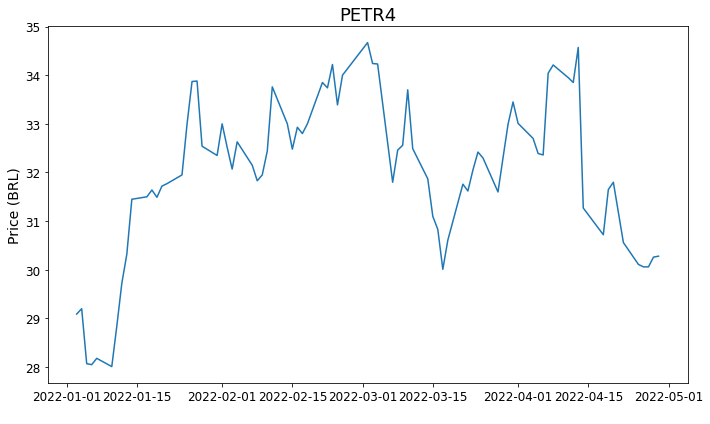

In [81]:
plt.figure(figsize = (10,6))
plt.plot(PETR4_df.Date, PETR4_df.Close)
plt.title('PETR4', fontsize = 18)

plt.xlabel(' ')
plt.ylabel('Price (BRL)', fontsize = 14)

plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)

plt.tight_layout( )

The stock presents a lot of volatility: it had moments where it dropped very quickly, but it also increased in value in some periods. We can also evaluate the percentual change in each day:

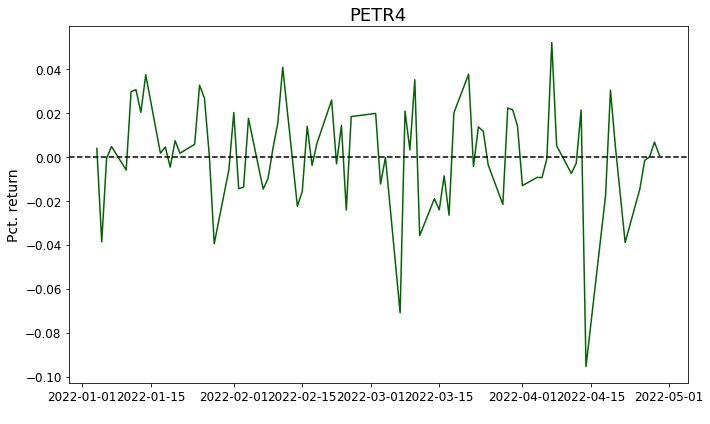

In [82]:
plt.figure(figsize = (10,6))
plt.plot(PETR4_df.Date, PETR4_df.Close.pct_change( ), color = 'darkgreen')
plt.axhline(0, color='k', linestyle='--')
plt.title('PETR4', fontsize = 18)

plt.xlabel(' ')
plt.ylabel('Pct. return', fontsize = 14)

plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)

plt.tight_layout( )

Indeed, it seems that the PETR4 stock has a very high volatility, with moments of ups and downs. It had moments where the stock raised almost 10% in a single day, but there were moments where it went the other way around. 

Now that we saw that we are indeed able to collect stock data, let's continue our project.

# Evaluating stock options return and risk

So, let's try to evaluate stock options by their return and risk. To this analysis, we will define a timeframe of 1 month. What would happen if we bought the PETR4 stock in '2022-02-02', and sold it one month later, in '2022-03-02'?


In [83]:
round(PETR4_df.query("Date == '2022-03-02'").Close.values[0] - PETR4_df.query("Date == '2022-02-02'").Close.values[0], 2)

2.15

We would get BRL 2.15 for each stock sold. Here, we got a single timeframe. However, in reality, we could have gotten any random initial day, and picked a specific timeframe.

Let's try to draw a graph where we have **the percentual return of a stock** after a **fixed timeframe** if we bought the stock at date **x**. First, let's create a function to get the return after a given period:

In [84]:
def GetReturnAfterTimeframe(stock, start, end, period):
  prices = GetStockData(stock, start, end).set_index('Date').Close
  prices.index = pd.to_datetime(prices.index)

  pct_returns = [ ]
  buy_dates  = [ ]

  for buy_date, buy_price in prices.iteritems( ):
    sell_date = buy_date + timedelta(weeks = period)

    # If we try to sell on a non-trading day, we skip
    try:
      sell_price = prices[prices.index == sell_date].iloc[0]
    except IndexError:
      continue

    # Get percentual return
    pct_return = (sell_price - buy_price)/buy_price

    pct_returns.append(pct_return)
    buy_dates.append(buy_date)

  return (buy_dates, pct_returns)

Note that, here, the timeframe should be given in **weeks**. Now, let's make a graph of the percentual returns if we bought the stock in a given date, and sold it four weeks later:

In [85]:
ticker = 'PETR4.SA'
start, end  = '2022-01-01', '2022-04-30'
period = 4

buy_dates, pct_returns = GetReturnAfterTimeframe(ticker, start, end, period)

Now, let's plot this graph:

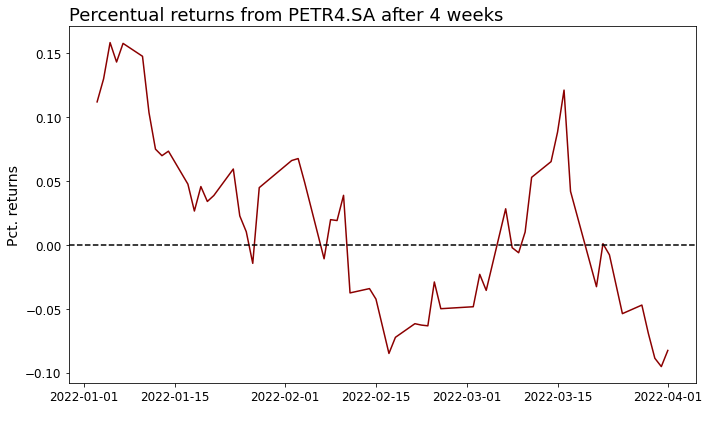

In [86]:
plt.figure(figsize = (10,6))
plt.plot(buy_dates, pct_returns, color = 'darkred')
plt.title('Percentual returns from ' + ticker + ' after ' + str(period) + ' weeks', fontsize = 18, loc = 'left')
plt.axhline(0, color='k', linestyle='--')

plt.xlabel(' ')
plt.ylabel('Pct. returns', fontsize = 14)

plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)

plt.tight_layout( )

Now, let's create a function to plot this graph and the stock price together:

In [87]:
def PlotStockAfterPeriodClose(stock, start, end, period):
  prices = GetStockData(stock, start, end).set_index('Date').Close
  prices.index = pd.to_datetime(prices.index)

  buy_dates, pct_returns = GetReturnAfterTimeframe(stock, start, end, period)

  plt.figure(figsize = (10,8))

  # Stock price

  plt.subplot(2,1,1)
  plt.plot(prices.index, prices)
  plt.title(stock, fontsize = 18)
  plt.xlabel(' ')
  plt.ylabel('Price (BRL)', fontsize = 14)
  plt.xticks(fontsize = 12)
  plt.yticks(fontsize = 12)

  # Stock return

  plt.subplot(2,1,2)
  plt.plot(buy_dates, pct_returns, color = 'darkred')
  plt.axhline(0, color='k', linestyle='--')
  plt.title('Percentual returns from ' + ticker + ' after ' + str(period) + ' weeks', fontsize = 18, loc = 'left')
  plt.xlabel(' ')
  plt.ylabel('Pct. return', fontsize = 14)
  plt.xticks(fontsize = 12)
  plt.yticks(fontsize = 12)

  plt.tight_layout( )

Now, we can do:

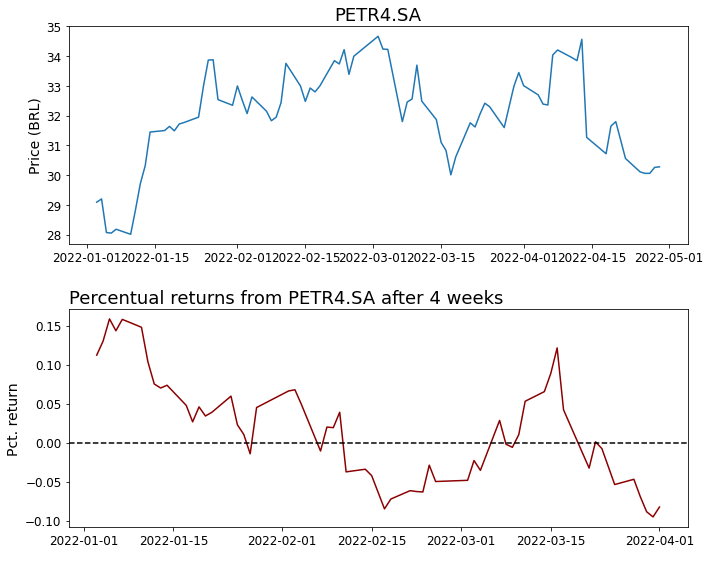

In [88]:
PlotStockAfterPeriodClose(ticker, start, end, period)

## Defining a metrics to evaluate the stock return and risk

Great. Now, from the graph of percentual returns, how can we evaluate if the stock is a good option (for randomly buying and selling after one month)? Well, we can simply take the mean of the percentual returns. And to evaluate the risk, we could use the standard deviation of the percentual returns.

Thus, we can do:

In [89]:
avg_ret = np.mean(pct_returns)
std_ret = np.std(pct_returns)

print(f"Avg. return: {round(avg_ret*100, 2)}% || Std. return: {round(std_ret*100, 2)}%")

Avg. return: 1.61% || Std. return: 6.75%


So, we have, on average, a return of 1.61% if we bought and sold after one month. Not a bad monthly return. However, note that the standard deviation is 6.75%. Thus, we run some risk when taking this approach.

## Evaluating metrics for all IBOV stocks

Now, let's try to evaluate these metrics for all stocks in the IBOV index (considering the same timeframe and a 4-week period between buy and sell dates). First, let's define a function to get the metrics:

In [90]:
def PerformAnalysisForStocks(stock, start, end, period):
  buy_dates, pct_returns = GetReturnAfterTimeframe(stock, start, end, period)
  return (np.mean(pct_returns), np.std(pct_returns))

Now, let's try to evaluate which were the best stocks, considering information from 2021:

In [91]:
start_time, end_time = '2021-01-01', '2021-12-31'
period     = 4

for stock in IBOV_Stocks:
  avg, std = PerformAnalysisForStocks(stock + '.SA', start, end, period)
  IBOV_Stocks_df.loc[IBOV_Stocks_df.Stocks == stock, 'Avg_return'] = avg*100
  IBOV_Stocks_df.loc[IBOV_Stocks_df.Stocks == stock, 'Std_return'] = std*100

## Define a plan for buying stocks

Finally, let's see the final dataframe, sort it by return, and get the 10 highest average returns in 2021:

In [92]:
IBOV_Stocks_df.sort_values(by = 'Avg_return', ascending = False).head(10)

,Stocks,Avg_return,Std_return
20,CIEL3,17.359506,13.140841
17,CRFB3,14.251137,8.046869
46,HYPE3,10.306479,6.722709
74,SBSP3,10.296420,8.569038
83,TOTS3,10.186998,8.214703
61,BEEF3,9.792817,9.952268
4,ASAI3,9.504620,9.242143
78,SULA11,9.484019,20.142968
52,JHSF3,9.418411,17.113499
63,MULT3,9.401596,11.552414


The stock for CIEL3 (CIELO) showed an average return of 17.35%! A very high average return. However, at the same time, it showed a high standard deviation: 13.14%. The second in the list, CRFB3 (Atacadão), also showed a high average return, but a lower deviation. The standard deviation is related to the risk involved in the stock. So, let's remove all stocks that have standard deviation higher than 10%:



In [93]:
Stocks_Filtered = IBOV_Stocks_df.query("Std_return < 10.0")
Stocks_Filtered.sort_values(by = 'Avg_return', ascending = False).head(10)

,Stocks,Avg_return,Std_return
17,CRFB3,14.251137,8.046869
46,HYPE3,10.306479,6.722709
74,SBSP3,10.296420,8.569038
83,TOTS3,10.186998,8.214703
61,BEEF3,9.792817,9.952268
4,ASAI3,9.504620,9.242143
24,CPFE3,8.999863,2.875050
8,BBSE3,8.428122,8.573575
31,ELET6,7.883246,7.067183
30,ELET3,7.873724,8.156826


Nice. Now, we have companies that showed the highest 4-week average returns, and also do not have a lot of risk involved. Thus, we could actually buy these stocks, and expected to get a good monthly return. To reduce our risk even more, we could also buy stocks with very low correlation (negative correlation). However, here, we will not worry about this. 

So, let's say that one buys BRL 1000,00 of these ten best stocks. How much money will we get between '2022-01-01' and '2022-04-30'? 

In [94]:
stocks_to_buy = list(Stocks_Filtered.sort_values(by = 'Avg_return', ascending = False).Stocks)[:10]

In [95]:
sum_returns = 0
curr_funds = 0
initial_investment = 1000

for stock in stocks_to_buy:
  amnt = initial_investment

  print('-'*30)
  print(stock)

  stock_df = GetStockData(stock + '.SA', '2022-01-01', '2022-04-30')
  stock_df.Date = pd.to_datetime(stock_df.Date)

  buy_price = stock_df.iloc[0].Close                      # First valid day

  num_shares = int(initial_investment / buy_price)        # Number of shares is the current funds divided by share price, rounded down
  shares_price = num_shares*buy_price
  amnt  -= shares_price                                   # Update amount of money we have
  rest = initial_investment - shares_price
  
  sell_price = stock_df.iloc[stock_df.index[-1]].Close    # Last valid day

  shares_price = num_shares*sell_price
  amnt  += shares_price                                   # Increase our amount of money by the number of shares sold times the price   

  curr_funds += rest + amnt
  percentual_return = (rest + amnt - initial_investment)/initial_investment
  print(f'Initial investment: {round(num_shares*buy_price, 2)}')
  print(f'Percentual return: {round(percentual_return, 2)}')
  print(f'Monetary return: {round(rest + amnt - initial_investment)}')
  
print('-'*30)
print(f'Total return: {round(curr_funds, 2)}')

------------------------------
CRFB3
Initial investment: 988.08
Percentual return: 0.44
Monetary return: 443
------------------------------
HYPE3
Initial investment: 988.2
Percentual return: 0.37
Monetary return: 371
------------------------------
SBSP3
Initial investment: 998.75
Percentual return: 0.12
Monetary return: 116
------------------------------
TOTS3
Initial investment: 990.0
Percentual return: 0.17
Monetary return: 171
------------------------------
BEEF3
Initial investment: 991.8
Percentual return: 0.26
Monetary return: 264
------------------------------
ASAI3
Initial investment: 992.16
Percentual return: 0.21
Monetary return: 208
------------------------------
CPFE3
Initial investment: 983.44
Percentual return: 0.41
Monetary return: 407
------------------------------
BBSE3
Initial investment: 988.8
Percentual return: 0.24
Monetary return: 243
------------------------------
ELET6
Initial investment: 969.0
Percentual return: 0.27
Monetary return: 267
------------------------

So, if we bought the ten best stocks (according to our criteria), we would get BRL 12744.79 (or a return of 27.44%) in 4 months. Very good! It seems that, in this specific period, brazilian stock market performed very well. None of our stocks showed negative returns. To get a comparison, let's see how much would we gain if we simply took BRL 10000.00 and invested in the IBOV index:

In [96]:
date, pct_return = GetReturnAfterTimeframe('^BVSP', '2022-01-01', '2022-04-30', 4)

print(f'Total return: {round(10000*pct_return[0], 2)}')

Total return: 814.65


If we had simply invested in the index itself, we would get a return of BRL 814.65 (or 8.14%) in 4 months. So, in this timeframe, our approach of choosing the last years' best stocks and buying them for the next four months actually showed much better returns!

Now, let's move on to the next topic, and try to build a more complex model.

# Model based on comportamental heuristics

Ok, we have implemented a very simple model, which basically analyses a stock average return and risk associated and decides whether to buy it or not. Now, we will implement a new model, this time based on comportamental heuristics. These reflect an instinct that we may have, and is studied in the behavioral economics.

https://en.wikipedia.org/wiki/Behavioral_economics#Behavioral_economics_concepts

So, when we buy stocks, we usually have two major instincts. First, we tend to thing that stocks that are increasing in value will continue to increase. Second, we really do not want to sell a stock if our return is negative. Here, we will try to create a model that implements these comportamental heuristics, and buys and sells stocks solely based on their recent behavior.

So, we our model will follow two basic protocols:

> Buying protocol: Buy if stock increases price for $n_b$ consecutive days.

> Selling protocol: Sell if stock decreases price for $n_s$ consecutive days (and we've made a profit).



## Implementation of buy-sell protocols

Ok. Now, let's make a function implementing these protocols:

In [97]:
# Defining the buying condition:

def buying_condition(sub_series):
      return (sub_series > 0).all( )       # If all values from the subseries are positive, returns 1 

# Defining the selling condition:

def selling_condition(sub_series):
      return (sub_series < 0).all( )       # If all values from the subseries are negative, returns 1 

In [98]:
def GetBuyingSellingDays(prices, nb, ns):  
  percent_change = prices.pct_change( )[1:]

  buying_days            = percent_change.rolling(nb).apply(buying_condition)

  potential_selling_days = percent_change.rolling(ns).apply(selling_condition)  # Potential because we still have to check if we've made a profit

  return {'buy_dates' : buying_days, 'sell_dates' : potential_selling_days}

Ok. Now, let's make a test. Let's get the buying and potential selling dates for BBAS3, considering $n_b = 3$ and $n_s = 3$:

In [157]:
prices = GetStockData('BBAS3.SA', '2022-01-01', '2022-04-30').set_index('Date').Close
prices.index = pd.to_datetime(prices.index)

dates_dict = GetBuyingSellingDays(prices, 3, 3)

We can see the buying dates using:

In [158]:
dates_dict['buy_dates'][dates_dict['buy_dates'] == 1]

Date
2022-01-10    1.0
2022-01-11    1.0
2022-01-12    1.0
2022-01-13    1.0
2022-01-14    1.0
2022-01-17    1.0
2022-01-18    1.0
2022-01-19    1.0
2022-01-20    1.0
2022-01-31    1.0
2022-02-14    1.0
2022-02-15    1.0
2022-02-16    1.0
2022-04-08    1.0
2022-04-11    1.0
2022-04-18    1.0
Name: Close, dtype: float64

And we can see the selling dates using:

In [159]:
dates_dict['sell_dates'][dates_dict['sell_dates'] == 1]

Date
2022-03-07    1.0
2022-04-01    1.0
2022-04-04    1.0
2022-04-05    1.0
2022-04-22    1.0
Name: Close, dtype: float64

Nice! Let's create a dataframe to store this information:

In [160]:
def GetBehaviorStocks_df(date_dict, prices):
  BehaviorStocks = pd.DataFrame(index = dates_dict['buy_dates'].index)

  # Store dataframe columns
  BehaviorStocks['buying_day'] = (dates_dict['buy_dates'] == 1)
  BehaviorStocks['potential_selling_day'] = (dates_dict['sell_dates'] == 1)
  BehaviorStocks['price'] = prices.values[1:]

  # If the day is neighter a buying nor a selling day, drop the row
  BehaviorStocks = BehaviorStocks[BehaviorStocks['buying_day'] | BehaviorStocks['potential_selling_day']]

  return BehaviorStocks

In [161]:
behavior_stocks = GetBehaviorStocks_df(dates_dict, prices)

behavior_stocks.head( )

,buying_day,potential_selling_day,price
Date,,,
2022-01-10,True,False,28.780001
2022-01-11,True,False,28.900000
2022-01-12,True,False,29.180000
2022-01-13,True,False,29.650000
2022-01-14,True,False,30.410000


## Getting investing dates

Now, note that we will just sell our stock if we've made a profit. Also, if we already have the stock, we will not buy it again.

First, let's create a function to check if the cumulative percentual change between a buy and a potential sell date yields overall growth:

In [162]:
def CheckCumulativePercentualChange(price_data, buy_day, sell_day):
  percentual_change = price_data.pct_change( )[1:]

  # Getting a temporary series with information about the percentual change on days between buy_day and sell_day
  tmp_series = 1 + percentual_change[buy_day+timedelta(hours = 1) : sell_day] 

  # The total percentual change is evaluated by multiplying all percentual changes from each day
  total_pct_change = tmp_series.product( )                                   

  # To check for an overall growth, we need to check if total_pct_change is higher than 1
  return total_pct_change > 1

Nice! Now, let's actually implement a function to get the buy and sell days:

In [163]:
def GetInvestingDays(behavior_data, starting_funds, verbose, IgnoreProfit = False):
  price_data = behavior_data.price

  # Define a boolean for holding. At the start, we are not holding any shares:
  holding = False

  # Declaring initial variables
  curr_funds    = starting_funds
  curr_shares   = 0
  last_buy_date = None
  events_list = [ ]

  for date, data in behavior_data.iterrows( ):

    # If we are not holding and if we are at a buying day, we buy the stock
    if (not holding) and (data.buying_day):
      num_shares_to_buy = int(curr_funds / data.price)     # Number of shares is the current funds divided by share price, rounded down

      curr_shares += num_shares_to_buy                     # Update current shares
      shares_price = num_shares_to_buy*data.price

      curr_funds  -= shares_price                          # Update current funds

      last_buy_date = date                                 # Storing last buy date
      events_list.append(('b', date))    

      holding = True                                       # Now we are holding shares

      if (verbose):
        print(f"Bought {num_shares_to_buy} shares at BRL {round(data.price, 2)} on {date.date( )} (spent: BRL {round(shares_price, 2)}, funds: BRL {round(curr_funds, 2)})")

    # If we are holding, we are at a potential selling day...
    elif (holding) and (data.potential_selling_day):
      # ...and if we made a profit, we sell the stock
      IsReturnPositive = CheckCumulativePercentualChange(price_data, last_buy_date, date)
      if IsReturnPositive or IgnoreProfit:

        shares_price = curr_shares*data.price
        curr_funds  += shares_price                        # Increase our current funds by the number of shares sold times the price   

        if (verbose):
          print(f"Sold {curr_shares} shares at BRL {round(data.price, 2)} on {date.date( )} (profit: BRL {round(shares_price, 2)}, funds: BRL {round(curr_funds, 2)})")
          print('-'*50)

        curr_shares = 0                                    # Reseting current shares

        holding = False                                    # No longer holding

        events_list.append(('s', date, IsReturnPositive)) 

    # At the end, let's evaluate the total asset (funds + stock value)

  end_price = price_data[-1]
  end_total_asset = curr_funds + end_price*curr_shares

  # Return the percentual change and the list of events
  return round((end_total_asset - starting_funds)/starting_funds*100, 2), events_list

In [164]:
start_funds = 10000

percent_change, events = GetInvestingDays(behavior_stocks, start_funds, True)

Bought 347 shares at BRL 28.78 on 2022-01-10 (spent: BRL 9986.66, funds: BRL 13.34)
Sold 347 shares at BRL 32.45 on 2022-03-07 (profit: BRL 11260.15, funds: BRL 11273.49)
--------------------------------------------------
Bought 323 shares at BRL 34.85 on 2022-04-08 (spent: BRL 11256.55, funds: BRL 16.94)


Nice! Now, let's get our total asset (funds + stock value) at the end of the period:

In [165]:
print(f"Total asset: {round((1 + percent_change/100)*start_funds, 2)}, percentual change: {percent_change}%")

Total asset: 11138.0, percentual change: 11.38%


So, if we implemented the buying and selling protocols for BBAS3 (considering $n_b = 3$ and $n_s = 3$), we would get BRL 11138.00, or a profit of 11.38% in four months.

## Plotting the events

Let's try to understand the buying and selling dates. For that end, let's try to plot them in the stock price graph:

In [166]:
def PlotPriceEventsList(price_data, events):
  plt.figure(figsize = (16, 8))
  plt.plot(price_data)

  shaded_lims = int(price_data.min( )*0.5), int(price_data.max( )*1.5)
  
  for idx, event in enumerate(events):
    color = 'darkgreen' if event[0] == 'b' else 'red'
    plt.axvline(event[1], color = color, linestyle = '--', alpha = 0.4)

    if event[0] == 's':
      fill_color = 'green' if (event[2] > 0) else 'red'
      plt.fill_betweenx(range(*shaded_lims), event[1], events[idx-1][1], color = fill_color, alpha = 0.1)

  plt.ylim([int(price_data.min( )*0.95), int(price_data.max( )*1.05)])

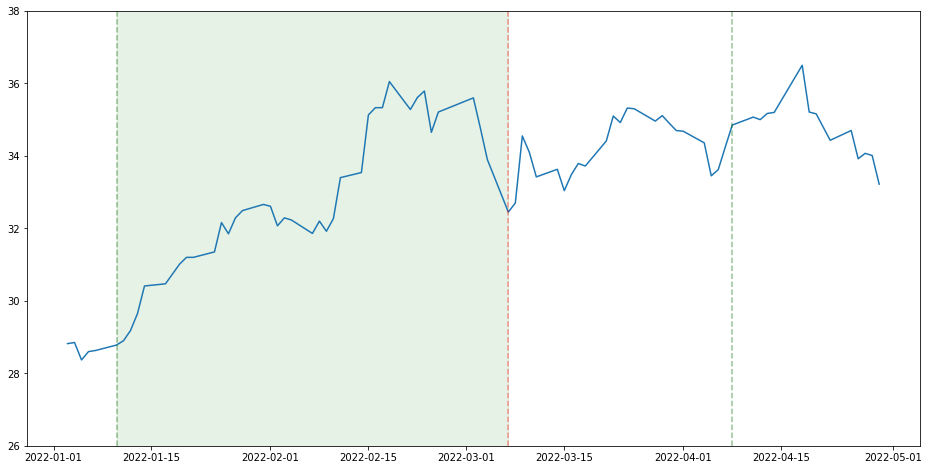

In [167]:
PlotPriceEventsList(prices, events)

So, here, we can see the buying and selling dates for the BBAS3 stock, considering our protocols (and $n_b = 3$ and $n_s = 3$). Note that we only sell the stock if we have made a profit. Thus, at the end of the period, we are actually holding the stock, since we have not found a new selling date. 

## Testing our model

So, in a initial testing, our model worked. Let's test it a little more, using different values for $n_b$ and $n_s$, and also getting the result for different stocks.

First, let's try to use a very low $n_b$ and $n_s$:

In [171]:
n_b, n_s = 1, 1
start_funds = 10000

prices = GetStockData('BBAS3.SA', '2022-01-01', '2022-04-30').set_index('Date').Close
prices.index = pd.to_datetime(prices.index)

dates_dict = GetBuyingSellingDays(prices, n_b, n_s)

behavior_stocks = GetBehaviorStocks_df(dates_dict, prices)

percent_change, events = GetInvestingDays(behavior_stocks, start_funds, False)

print(f"Total asset: {round((1 + percent_change/100)*start_funds, 2)}, percentual change: {percent_change}%")

Total asset: 11361.0, percentual change: 13.61%


So, actually, if someone was **VERY** aggressive in their buying and selling protocols, he would get a return of 13.61% in the same four months. That is a slightly higher return. Let's try to see the plot for this approach:

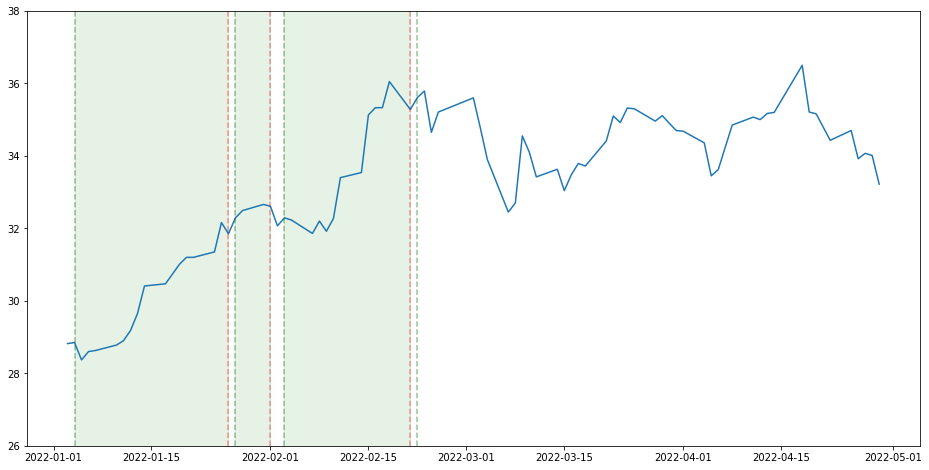

In [172]:
PlotPriceEventsList(prices, events)

This time, since the buying and selling protocols are very aggressive, the person buys and sells more. Still, we bought the stock at a point, and did not sell it again since we got no profit. 

Now, let's test $n_b = 5$ and $n_s = 5$:

In [174]:
n_b, n_s = 5, 5
start_funds = 10000

prices = GetStockData('BBAS3.SA', '2022-01-01', '2022-04-30').set_index('Date').Close
prices.index = pd.to_datetime(prices.index)

dates_dict = GetBuyingSellingDays(prices, n_b, n_s)

behavior_stocks = GetBehaviorStocks_df(dates_dict, prices)

percent_change, events = GetInvestingDays(behavior_stocks, start_funds, False)

print(f"Total asset: {round((1 + percent_change/100)*start_funds, 2)}, percentual change: {percent_change}%")

Total asset: 11460.0, percentual change: 14.6%


Now, the percentual change is also pretty high (14.6%). Let's draw the plot:

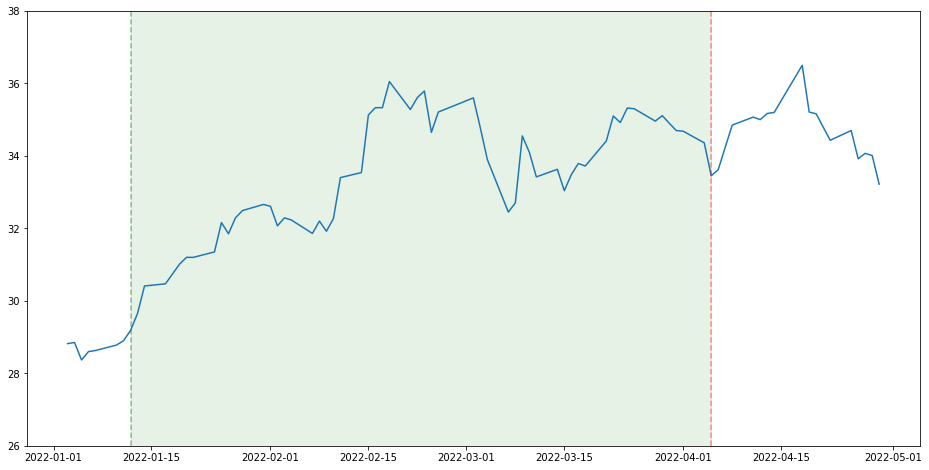

In [176]:
PlotPriceEventsList(prices, events)

Actually, here, we bought the stock at a point, and never sold it (because we never found a selling condition). So, even though we got a good profit here, we may pass a long time without selling the stock.

Finally, let's test using $n_b = 3$ and $n_s = 1$:

In [178]:
n_b, n_s = 3, 1
start_funds = 10000

prices = GetStockData('BBAS3.SA', '2022-01-01', '2022-04-30').set_index('Date').Close
prices.index = pd.to_datetime(prices.index)

dates_dict = GetBuyingSellingDays(prices, n_b, n_s)

behavior_stocks = GetBehaviorStocks_df(dates_dict, prices)

percent_change, events = GetInvestingDays(behavior_stocks, start_funds, False)

print(f"Total asset: {round((1 + percent_change/100)*start_funds, 2)}, percentual change: {percent_change}%")

Total asset: 10926.0, percentual change: 9.26%


Here, we got a lower return (9.26%). Let's see our plot:

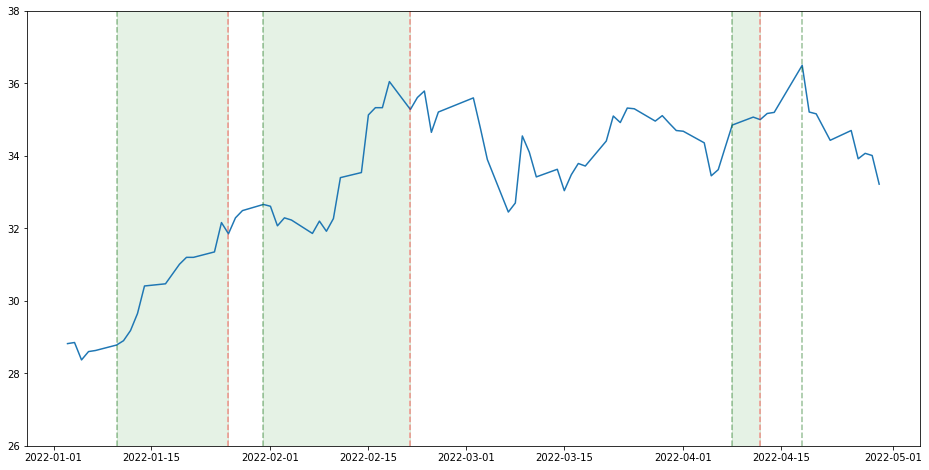

In [179]:
PlotPriceEventsList(prices, events)

Here, we are more conservative with our buys, but we sell the stock as soon as we see it going down (and we've made a profit). This alternative might be a good choice to balancing aggressive selling and a more conservative buying.

So, in terms of profit, it seems that the agressive option gets the highest return. However, being that aggressive may show very bad returns when we have falling stocks. At the same time, the conservative option shows a very passive investing behavior, where we basically never sell the stock. So, here, we will adopt the balanced approach to perform our investments.

## Comparing with previous options

So, after comparing some options, the $n_b = 3$ and $n_s = 1$ cases seems like a good balanced approach. Note that we could try to optimize these values, but this will not be performed here. So, let's try to use the approach to perform investments in those 10 best stocks we defined earlier. Thus, we can do:

In [116]:
n_b, n_s = 3, 1
start_funds_each_stock = 1000
sum_returns = 0

for stock in stocks_to_buy:

  print('-'*30)
  print(stock)

  prices = GetStockData(stock + '.SA', '2022-01-01', '2022-04-30').set_index('Date').Close
  prices.index = pd.to_datetime(prices.index)

  dates_dict = GetBuyingSellingDays(prices, n_b, n_s)

  behavior_stocks = GetBehaviorStocks_df(dates_dict, prices)

  percent_change, events = GetInvestingDays(behavior_stocks, start_funds_each_stock, False)
  stock_return = start_funds_each_stock*(1 + percent_change/100)
  sum_returns += stock_return

  print(f'Percentual return: {round(percent_change, 2)}%')
  print(f'Monetary return: {round(stock_return, 2)}')

print(f"\n\nTotal asset: {round(sum_returns, 2)}")

------------------------------
CRFB3
Percentual return: 28.37%
Monetary return: 1283.7
------------------------------
HYPE3
Percentual return: 21.66%
Monetary return: 1216.6
------------------------------
SBSP3
Percentual return: 24.64%
Monetary return: 1246.4
------------------------------
TOTS3
Percentual return: 13.62%
Monetary return: 1136.2
------------------------------
BEEF3
Percentual return: 5.9%
Monetary return: 1059.0
------------------------------
ASAI3
Percentual return: 13.31%
Monetary return: 1133.1
------------------------------
CPFE3
Percentual return: 17.67%
Monetary return: 1176.7
------------------------------
BBSE3
Percentual return: 23.97%
Monetary return: 1239.7
------------------------------
ELET6
Percentual return: 4.17%
Monetary return: 1041.7
------------------------------
ELET3
Percentual return: 12.43%
Monetary return: 1124.3


Total asset: 11657.4


Using our new model based on comportamental heuristics, we actually got a return of 16.57% in four months. A very good return, and better than IBOV index itself. This model is very interesting because, for a given period, the model itself tells us when should we buy and sell stocks (inside this period).

# Stock forecasting using ARMA model

Ok, now, let's try to build an actual model to forecast our stocks and, thus, decide buying and selling dates based on its prediction. Here, we will use the Autoregressive-Moving Averages (ARMA) model. First, to use an ARMA model, we need to make sure that our time series is stationary (constant mean, constant volatility). If we simply look at the stock price fluctation, we will soon note that it is not: stocks tend to increase in value as time passes. For example purposes, we will use here the BBAS3 stock (for company Banco do Brasil).

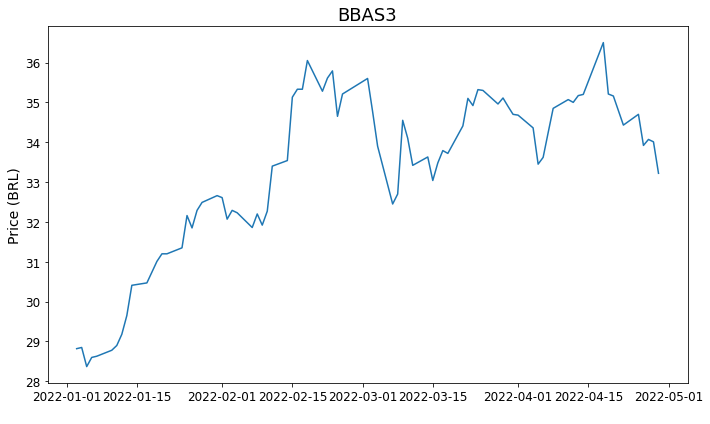

In [117]:
BBAS3_df = GetStockData('BBAS3.SA', '2022-01-01', '2022-04-30').set_index('Date')
BBAS3_df.index = pd.to_datetime(BBAS3_df.index)

plt.figure(figsize = (10,6))
plt.plot(BBAS3_df.index, BBAS3_df.Close)
plt.title('BBAS3', fontsize = 18)

plt.xlabel(' ')
plt.ylabel('Price (BRL)', fontsize = 14)

plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)

plt.tight_layout( )

## Making our series stationary

So, to make our time series closer to a stationary series, we can, instead, try to predict the returns:

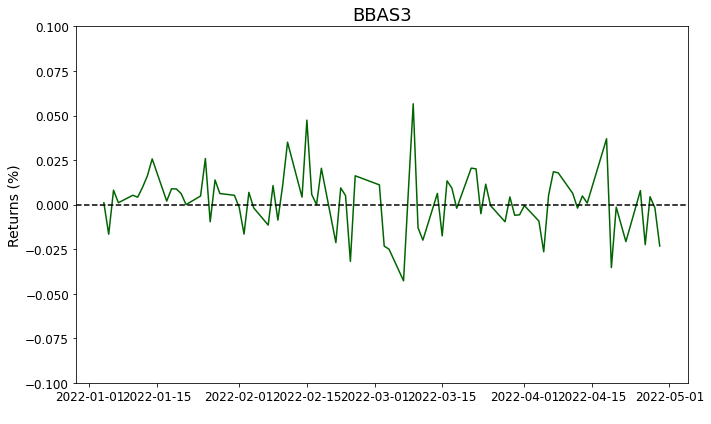

In [118]:
BBAS3_df['Returns'] = BBAS3_df.Close.pct_change( )
BBAS3_df.dropna(inplace = True)

plt.figure(figsize = (10,6))
plt.plot(BBAS3_df.index, BBAS3_df.Returns, color = 'darkgreen')
plt.axhline(0, color='k', linestyle='--')
plt.title('BBAS3', fontsize = 18)

plt.xlabel(' ')
plt.ylabel('Returns (%)', fontsize = 14)

plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)

plt.ylim([-0.1, 0.1])

plt.tight_layout( )

The returns series looks much closer to a stationary series.

## Analizing the ACF and PACF plots

So, before fitting the ARMA model, it is important to plot the Autocorrelation function and the Partial Autocorrelation function. These may give us a hint on the model order we should be using.

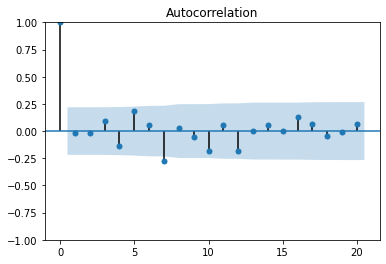

In [119]:
plot_acf(BBAS3_df.Returns)
plt.show( )

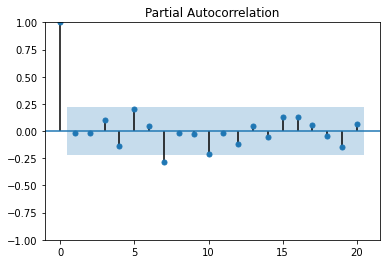

In [120]:
plot_pacf(BBAS3_df.Returns)
plt.show( )

Note that most lags have a very low correlation with the stock return. This shows us how hard it is to create a model to predict stock pricing: the price usually depends on multiple external factors besides the time series itself. Still, let's try to build our ARMA model, and see how well it does.

We see that, both in the ACF and PACF plots, lag 5 is the first lag with a higher correlation. Note that the ACF helps us with the order of the MA model, while the PACF helps us with the order of the AR model.



## Implementing and testing our ARMA model


Now that we understood more about the problem, let's make a function to fit an ARMA model and get the model forecast. Some important things to keep in mind: When modeling time series using autoregressive models, the longer you try to forecast, the worse your model becomes. Thus, we will always fit the model using a number of days, and try to forecast only the first next day. Then, we will check if the predicted return in the following day is higher than a given threshold. If so, we will buy the stock (if we are not holding). Then, here, we only keep the stock if the prediction is, again, higher than the threshold. 

So, let's implement our model:

In [184]:
def ARMAInvesting(returns, prices, initial_funds, order, threshold, verbose, plot_graph):
  # Set initial variables
  holding = False
  events_list = []
  curr_shares = 0
  curr_funds  = initial_funds

  pred_return = 1

  # Make a loop to fo through dates
  # Since we can't make predictions in the first first days (since we don't have previous information), 
  # we will only start predicting after 21 days
  for date, r in returns.iloc[21:].to_frame( ).iterrows( ):
    # Get returns until current date
    curr_data = returns[:date]

    # Fit ARIMA model
    model = ARIMA(curr_data, order = order).fit( )

    # Get prediction for the next day (forecast)
    pred = model.forecast( ).values[0]

    # If prediction is higher than a threshold and not holding, buy the stock
    if (not holding) and (pred >= threshold):
      holding = True

      num_shares_to_buy = int(curr_funds / prices.loc[date])     # Number of shares is the current funds divided by share price, rounded down

      curr_shares += num_shares_to_buy                           # Update current shares
      shares_price = num_shares_to_buy*prices.loc[date]

      curr_funds  -= shares_price                                # Update current funds

      buy_price = prices.loc[date]
      events_list.append(('b', date))
      if verbose:
        print(f"Bought {num_shares_to_buy} shares at BRL {round(buy_price, 2)} on {date.date( )} (spent: BRL {round(shares_price, 2)}, funds: BRL {round(curr_funds, 2)})")

    # If currently holding, sell (if our return is higher than the threshold, we will buy it again)
    if holding and (pred < threshold):
      sell_price = prices.loc[date]
      curr_holding = False
      gain = (sell_price - buy_price)/buy_price
      IsReturnPositive = 1 if gain > 0 else 0
      events_list.append(('s', date, IsReturnPositive))
      
      shares_price = curr_shares*sell_price
      curr_funds  += shares_price                        # Increase our current funds by the number of shares sold times the price  
      
      holding = False

      if verbose:
        print(f"Sold {curr_shares} shares at BRL {round(sell_price, 2)} on {date.date( )} (profit: BRL {round(shares_price, 2)}, funds: BRL {round(curr_funds, 2)})")
        print('-'*50)

      curr_shares = 0

  # In the end, evaluate the total asset and the end return
  total_asset = round(curr_funds + curr_shares*prices.loc[prices.index[-1]], 2)
  end_return  = round((total_asset - initial_funds)/initial_funds*100, 2)

  if verbose:
    print(f"Total asset: {total_asset}")

  # Plot graph
  if plot_graph:
    PlotPriceEventsList(prices, events_list)
    plt.title(f'Threshold: {threshold}\nTotal asset: BRL {total_asset}\nTotal return: {end_return}%', fontsize = 18)
    plt.show( )

  return total_asset

Nice! Now, let's try to run an AR1 model, and see how much would we get in the period. Initially, we will consider a threshold of 0, which means that if we predict that our returns will be positive we buy the stock.

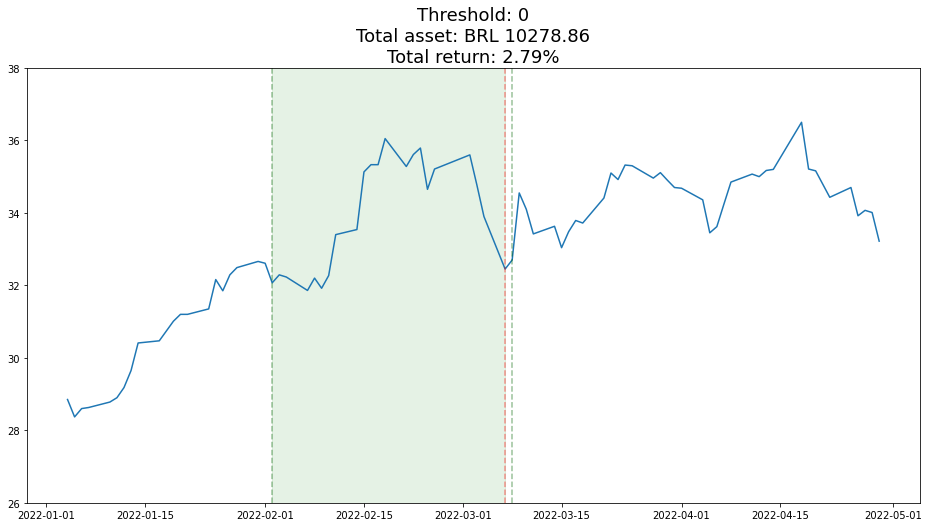

10278.86

In [185]:
funds = 10000
order = (1, 0, 0)
thrsh = 0

ARMAInvesting(BBAS3_df.Returns, BBAS3_df.Close, funds, order, thrsh, False, True)

Using this approach, we would get a 2.79% return during this timeframe. Now, let's try to increase our threshold, so that we only buy/keep the stock if our predicted return in the day is higher than 0.2%:

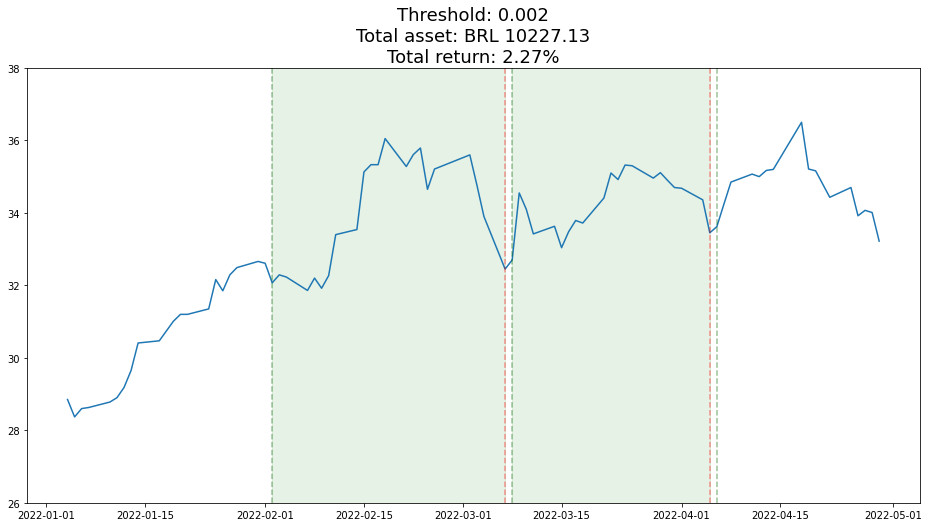

In [186]:
funds = 10000
order = (1, 0, 0)
thrsh = 0.002

total_asset = ARMAInvesting(BBAS3_df.Returns, BBAS3_df.Close, funds, order, thrsh, False, True)

This time, we would actually get a slightly lower return. This time, let's increase our AR model order to 5:

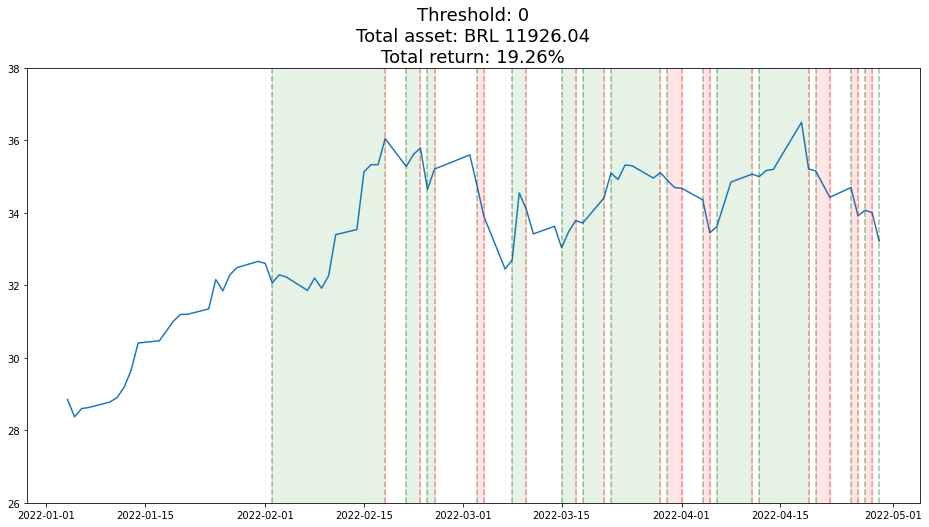

In [194]:
funds = 10000
order = (5, 0, 0)
thrsh = 0

total_asset = ARMAInvesting(BBAS3_df.Returns, BBAS3_df.Close, funds, order, thrsh, False, True)

Nice! Using an AR5 model, we got a much better return! Almost 20% in four months. Now, let's try an MA5 model:

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


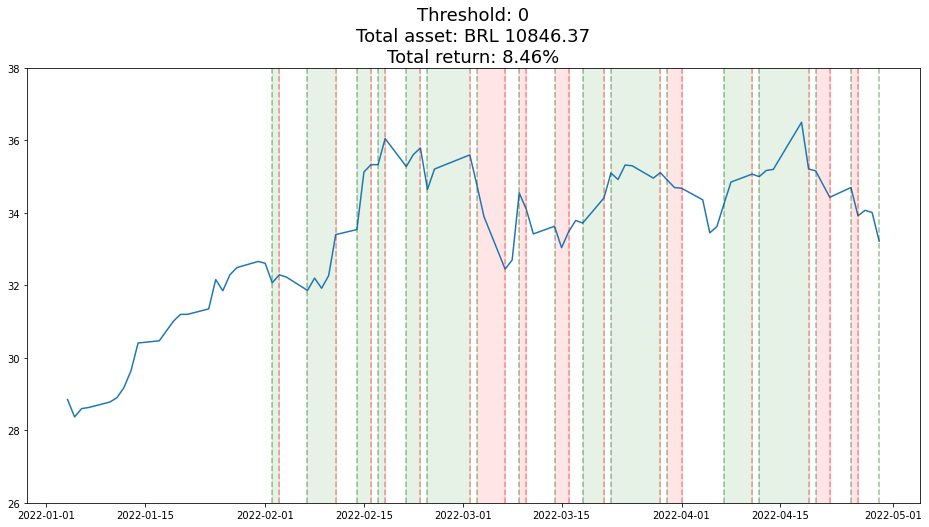

In [195]:
funds = 10000
order = (0, 0, 5)
thrsh = 0

total_asset = ARMAInvesting(BBAS3_df.Returns, BBAS3_df.Close, funds, order, thrsh, False, True)

Using a MA5 model, we also get a pretty high return. Now, let's finally use an ARMA model, with AR order 5 and MA order 5:

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


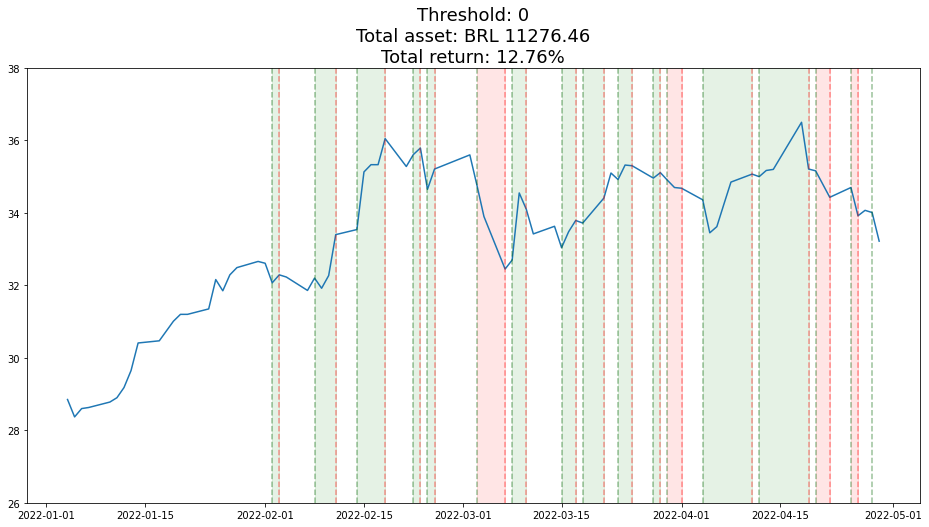

In [193]:
funds = 10000
order = (5, 0, 5)
thrsh = 0

total_asset = ARMAInvesting(BBAS3_df.Returns, BBAS3_df.Close, funds, order, thrsh, False, True)

So, using an ARMA(5,5) model we got a 12.76% return in four months. That is a pretty good return for this period. Also, it is clear that using order 5 helped the model. 

## Comparing with previous options

Now, let's try to the same approach with other stocks. First, let's create a function to help us:

In [196]:
def GetARMAInvestingResult(stock, start, end, funds, order, thrsh, verbose, plot):
  stock_df = GetStockData(stock + '.SA', start, end).set_index('Date')
  stock_df.index = pd.to_datetime(stock_df.index)

  stock_df['Returns'] = stock_df.Close.pct_change( )
  stock_df.dropna(inplace = True)

  return ARMAInvesting(stock_df.Returns, stock_df.Close, funds, order, thrsh, False, True)

Nice! Now, let's try to use the ARMA model to those 10 best stocks defined earlier:

------------------------------
CRFB3


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


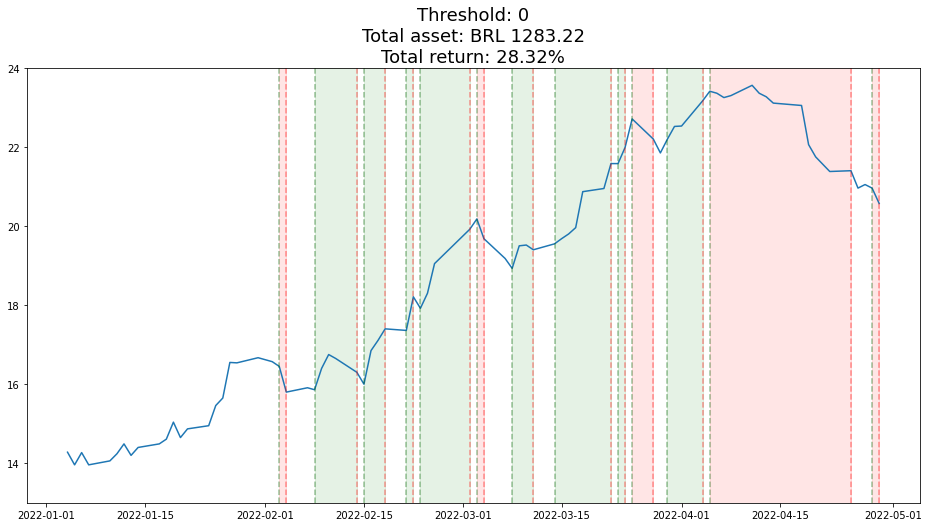

Initial investment: 1000
Percentual return: 0.28
Monetary return: 283.22
------------------------------
HYPE3


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


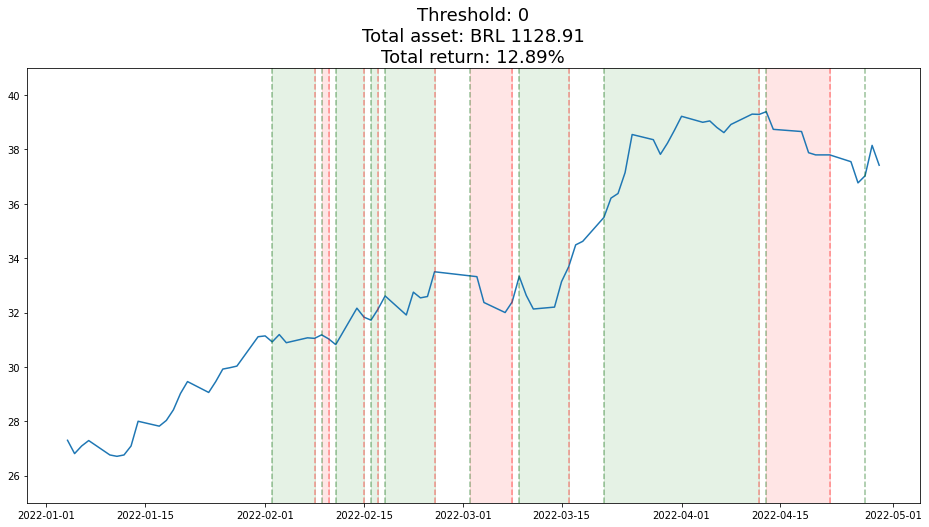

Initial investment: 1000
Percentual return: 0.13
Monetary return: 128.91
------------------------------
SBSP3


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


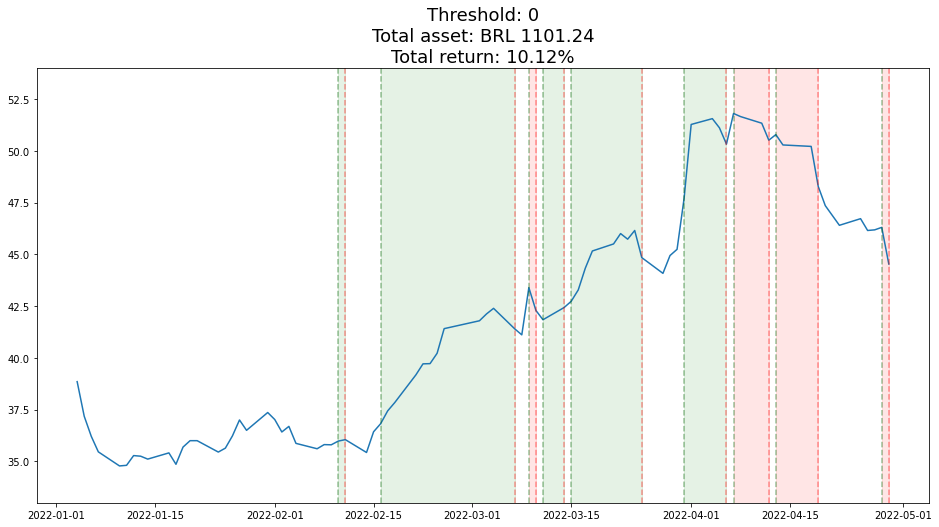

Initial investment: 1000
Percentual return: 0.1
Monetary return: 101.24
------------------------------
TOTS3


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


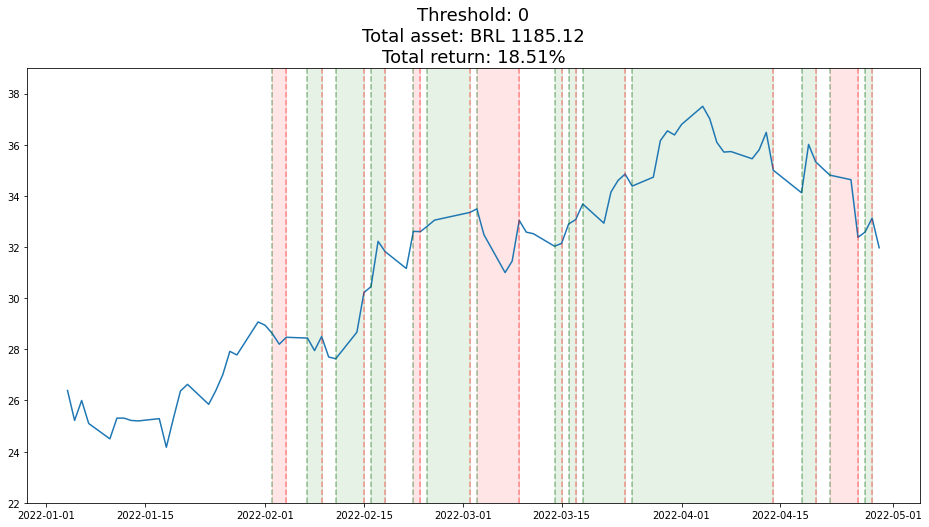

Initial investment: 1000
Percentual return: 0.19
Monetary return: 185.12
------------------------------
BEEF3


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


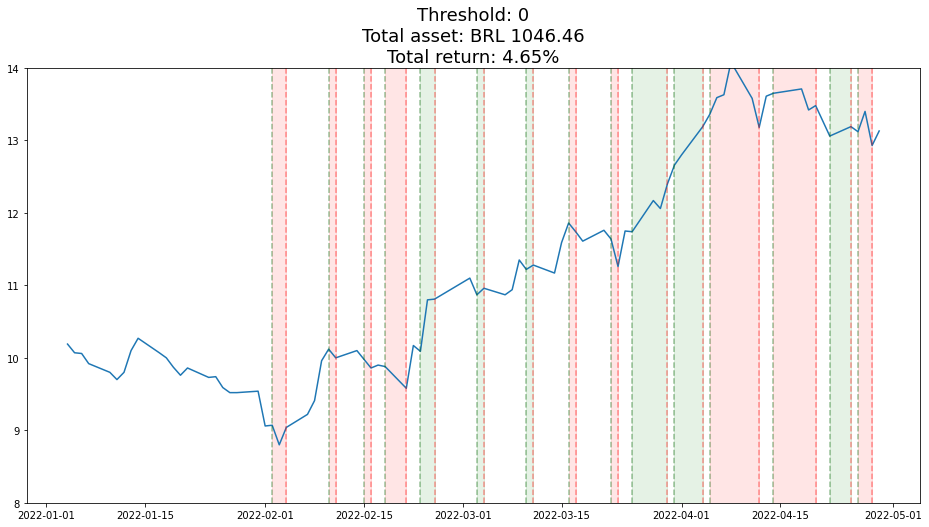

Initial investment: 1000
Percentual return: 0.05
Monetary return: 46.46
------------------------------
ASAI3


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


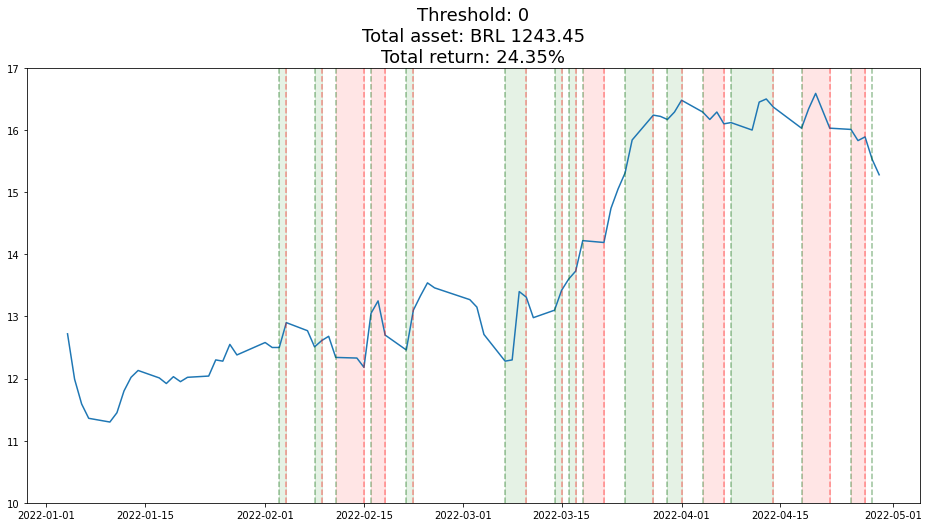

Initial investment: 1000
Percentual return: 0.24
Monetary return: 243.45
------------------------------
CPFE3


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


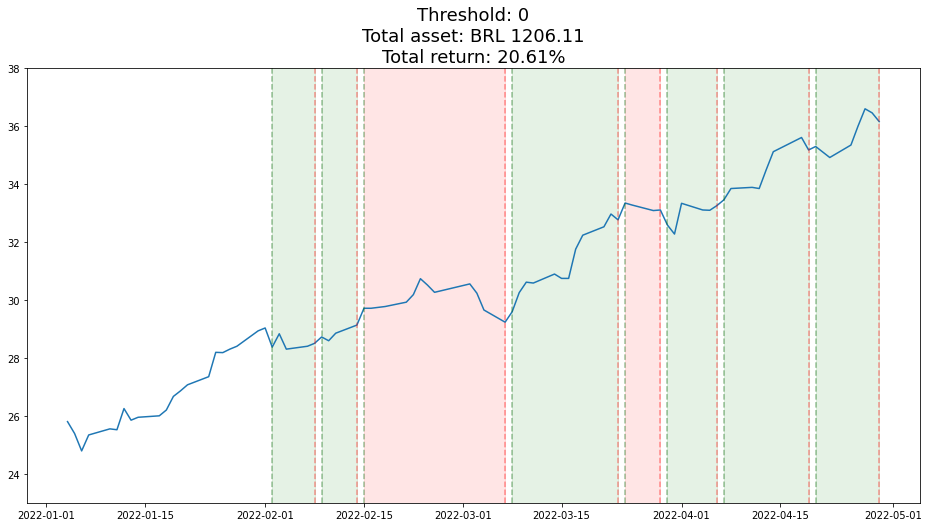

Initial investment: 1000
Percentual return: 0.21
Monetary return: 206.11
------------------------------
BBSE3


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


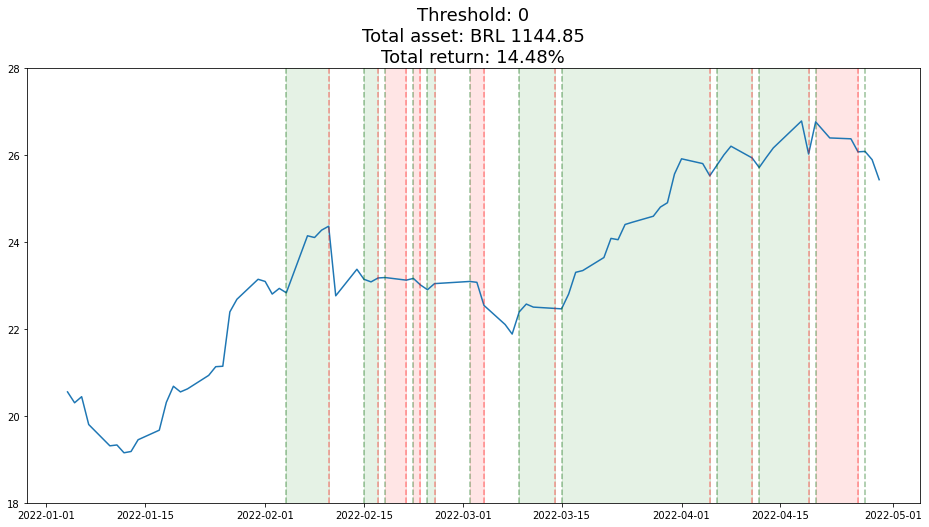

Initial investment: 1000
Percentual return: 0.14
Monetary return: 144.85
------------------------------
ELET6


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


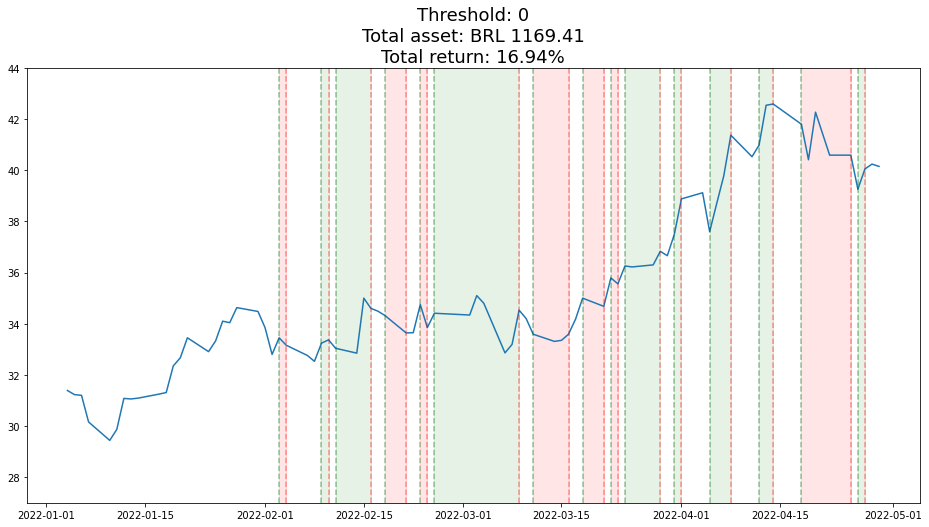

Initial investment: 1000
Percentual return: 0.17
Monetary return: 169.41
------------------------------
ELET3


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


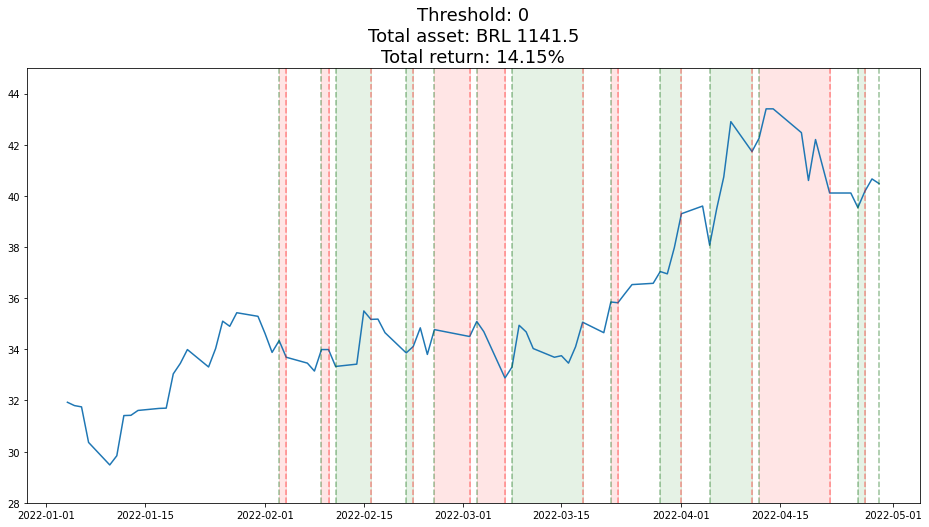

Initial investment: 1000
Percentual return: 0.14
Monetary return: 141.5
------------------------------
Total return: 11650.27


In [197]:
sum_returns = 0

start, end = '2022-01-01', '2022-04-30'
order = (5, 0, 5)
threshold = 0
initial_investment_per_stock = 1000

for stock in stocks_to_buy:
  print('-'*30)
  print(stock)

  total_asset = GetARMAInvestingResult(stock, start, end, initial_investment_per_stock, order, thrsh, False, False)

  sum_returns += total_asset
  percentual_return = (total_asset - initial_investment)/initial_investment
  print(f'Initial investment: {round(initial_investment, 2)}')
  print(f'Percentual return: {round(percentual_return, 2)}')
  print(f'Monetary return: {round(total_asset - initial_investment, 2)}')
  
print('-'*30)
print(f'Total return: {round(sum_returns, 2)}')

In the end, we got a total asset of BRL 11650.27, or a return of 16.50%. This is very similar to the return found when using the previous model, based on comportamental heuristics.

# Final recommendations

So, in this project, we showed how to analyze stock options using Python. First, we showed how to get the daily prices for stocks from the Yahoo Finance site. Then, we performed an initial basic analysis, where we defined the "best" stocks based on the average returns and risk. 

Then, we implemented a very simple model based on comportamental heuristics: here, one would buy stocks that show consecutive increases in their price, and sell stocks that show consecutive decreases in their price. Also, one will only sell the stock if one has made a profit. We showed that, performing this approach, we could get a very high return (more than 16% in 4 months), considering those best stocks defined earlier.

Finally, we used an ARMA model to forecast stock returns. Based on these predicted returns, we could then define when to buy or sell stocks. Using this approach, when compared to the previous method, we were able to get a very similar return (more than 16% in 4 months).

Note that, even though we got high returns with our approaches, stock trading is very complex, and previous returns do not guarantee future returns. Thus, before investing in stocks, the person should understand the risks of this type of investment.